In [213]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import matplotlib.cm as cm
warnings.filterwarnings('ignore')

%matplotlib inline

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs
plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
sns.set(style="whitegrid") # seteando tipo de grid en seaborn
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [214]:
airline_data = pd.read_csv("/content/drive/MyDrive/tp1- orga de datos/Datos clientes/airline_data.csv", parse_dates = ["date"])
cleaned_reviews = pd.read_csv("/content/drive/MyDrive/tp1- orga de datos/Datos clientes/cleaned-reviews.csv", parse_dates = ["date"])
costumer_data = pd.read_csv("/content/drive/MyDrive/tp1- orga de datos/Datos clientes/customer_airways_data.csv", encoding = "iso-8859-1")
costumer_data_filtrada = pd.read_csv("/content/drive/MyDrive/tp1- orga de datos/Datos clientes/filtered_customer_booking.csv")
costumer_data = costumer_data.drop_duplicates()#eliminamos filas duplicadas

# **1er .Analisis de preferencias en los vuelos y como influye en el rating**

In [215]:
costumer_data_filtrada["sales_channel"] = costumer_data_filtrada["sales_channel"].astype("category")
costumer_data["sales_channel"] = costumer_data["sales_channel"].astype("category")

In [216]:
preferencias = costumer_data.iloc[:,8:12]
preferencias = preferencias.rename(columns={"booking_origin": "country"})

In [217]:
def corregir_rates(serie):
  if(serie == "None"):
    return -1
  elif(serie == "\n\t\t\t\t\t\t\t\t\t\t\t\t\t5"):
    return 5
  else:
    return serie

airline_data.rates = airline_data.rates.map(corregir_rates)
airline_data.rates = airline_data.rates.astype(np.int8)

In [218]:
datos_filtrados = airline_data.iloc[:,[2,4]]
datos_encuesta = pd.merge(datos_filtrados,preferencias,how = "outer")
datos_encuesta_validos =datos_encuesta[datos_encuesta.rates > 0 ]
datos_encuesta_completos = datos_encuesta_validos.dropna()
datos_encuesta_completos["country"].value_counts()
conteo_paises = datos_encuesta_completos['country'].value_counts().reset_index()
conteo_paises.columns = ['country', 'conteo_pais']
conteo_paises = conteo_paises.head(5)


In [219]:
promedio_por_paises = datos_encuesta_completos.groupby('country')[['wants_in_flight_meals', 'wants_extra_baggage', 'wants_preferred_seat', 'rates']].mean().reset_index()
promedio_por_paises = promedio_por_paises.sort_values("rates", ascending=False)
paises_mas_encuestas_con_promedios = conteo_paises.merge(promedio_por_paises, on='country', how='inner')
paises_mas_encuestas_con_promedios = paises_mas_encuestas_con_promedios.iloc[:,[0,2,3,4,5]]
paises_mas_encuestas_con_promedios.set_index('country', inplace=True)

In [220]:
paises_mas_encuestas_con_promedios.index = ["Australia","Reino unido","Estados Unidos","Malasia","China"]
paises_mas_encuestas_con_promedios.columns = ["Quiere comidas en el vuelo","Quiere equipaje adicional","Quiere un asiento en particular","puntajes de vuelo"]

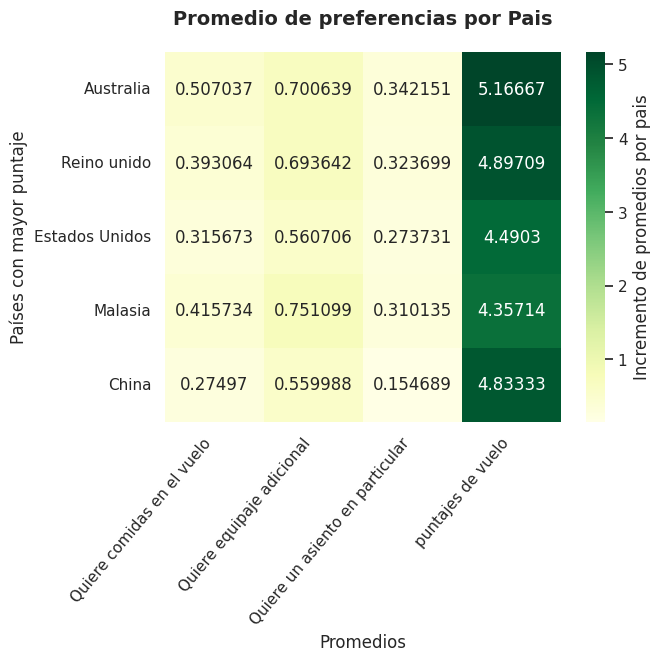

In [221]:
sns.heatmap(paises_mas_encuestas_con_promedios, annot=True, cmap="YlGn", fmt="g")
ejes = plt.gca()
ejes.set_xticklabels(ejes.get_xticklabels(), rotation=50, ha='right')
plt.title('Promedio de preferencias por Pais',pad = 20, fontsize=14,fontweight='bold')
plt.xlabel('Promedios')
plt.ylabel('Países con mayor puntaje')
colorbar = plt.gca().collections[0].colorbar
colorbar.set_label('Incremento de promedios por pais')
plt.show()

# **2 Analisis de la relacion entre los destinos mas visitados y que ruta elijieron **

In [222]:
informacion_de_compra = costumer_data_filtrada[["route", "trip_type", "sales_channel", "booking_complete", "purchase_lead", "booking_origin"]]
informacion_de_compra = informacion_de_compra.rename(columns={"booking_origin": "country"})
fecha_de_viaje = cleaned_reviews[["date", "verified","country"]]
informacion_de_vuelo = pd.merge(informacion_de_compra, fecha_de_viaje, how="outer")

In [223]:
informacion_de_vuelo = informacion_de_vuelo.dropna()
vuelos_validos = informacion_de_vuelo.loc[(informacion_de_vuelo.booking_complete == 1) & (informacion_de_vuelo.verified == True)]
paises_y_rutas = vuelos_validos.groupby(["country", "route"]).agg(cant_de_rutas_por_pais=('route', 'count')).reset_index()

In [224]:
vuelos_preferidos = paises_y_rutas.sort_values(["cant_de_rutas_por_pais"],ascending=False)
maxima_cantidad_personas = vuelos_preferidos.reset_index().groupby('country')['cant_de_rutas_por_pais'].idxmax()
ruta_mas_elegida_pais = vuelos_preferidos.reset_index().loc[maxima_cantidad_personas]
ruta_mas_elegida_pais = ruta_mas_elegida_pais.sort_values("cant_de_rutas_por_pais", ascending= False)
ruta_mas_elegida_pais = ruta_mas_elegida_pais.iloc[:,1:]

In [225]:
top_10_rutas = ruta_mas_elegida_pais.head(10)
top_10_rutas = top_10_rutas[["country","route","cant_de_rutas_por_pais"]]
rutas_elegidas  =top_10_rutas.pivot(index="country",columns="route",values="cant_de_rutas_por_pais").fillna(0)
rutas_elegidas.index = ["Australia","China","Hong Kong","Malasia","Singapur","Corea del Sur","Taiwan","Tailandia","Reino Unido","Estados Unidos"]
rutas_elegidas["total"] = rutas_elegidas.sum(axis=1)

In [226]:
rutas_elegidas = rutas_elegidas.sort_values("total",ascending =True)
rutas_elegidas = rutas_elegidas.drop(columns="total")

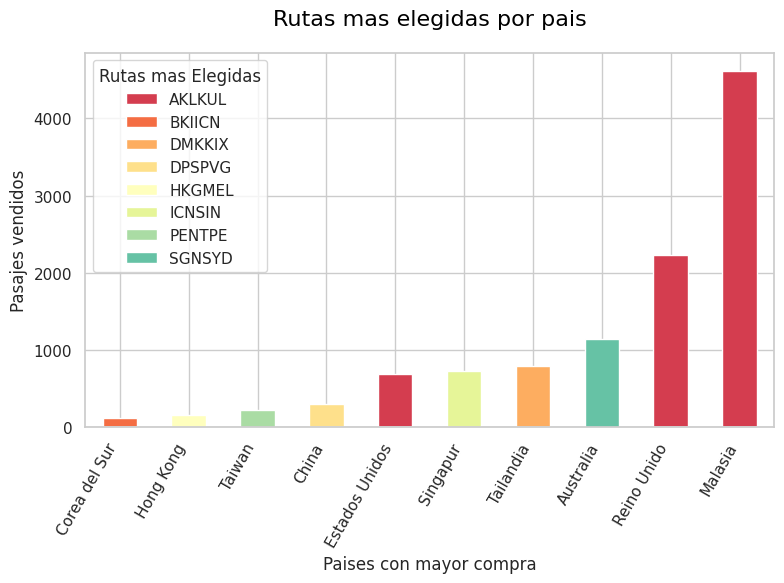

In [227]:
sns.set_palette("Spectral",n_colors=9)
rutas_elegidas.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.xlabel('Paises con mayor compra')
plt.ylabel('Pasajes vendidos')
plt.title('Rutas mas elegidas por pais', fontsize=16, color='Black', loc='center', pad=20)
ejes = plt.gca()
ejes.set_xticklabels(rutas_elegidas.index, rotation=60, ha='right')
plt.legend(title='Rutas mas Elegidas')
plt.tight_layout()
plt.show()

# Analisis de promedio de pasajeros por medio de compra de los paises que mas venta tuvieron de pasajes

In [228]:
info_de_compra = costumer_data_filtrada[["num_passengers","length_of_stay","flight_hour","flight_day","booking_origin","sales_channel"]]
filtro = (info_de_compra["booking_origin"] != "(not set)")
info_de_compra =info_de_compra[filtro]
datos_de_pasajeros = info_de_compra[["num_passengers","sales_channel","booking_origin"]]

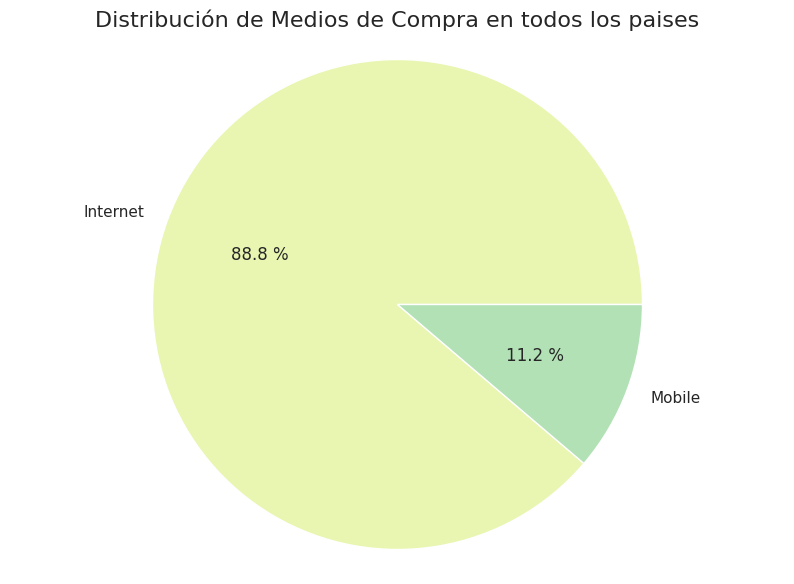

In [229]:
# vemos que medio de compra se usa mas en todo el mundo -> en base a esto suponemos que el medio de compra con mas porcentaje sera el utilizado por los top 10 paises que mas venta de pasajes tuvieron
medio_de_compras = datos_de_pasajeros.sales_channel.value_counts()
medio_de_compras = medio_de_compras.to_frame()
medio_de_compras.reset_index(inplace = True)
medio_de_compras.columns = ["medio de compra", "ventas totales"]

sns.set_palette("YlGnBu")
plt.figure(figsize=(10,7))
plt.pie(medio_de_compras["ventas totales"], labels= medio_de_compras["medio de compra"], autopct='%0.1f %%')
plt.title('Distribución de Medios de Compra en todos los paises', fontsize= 16, loc= 'center')
plt.axis('equal')
plt.show()

In [230]:
promedio_pasajeros = datos_de_pasajeros.groupby(["booking_origin","sales_channel"])[["num_passengers"]].mean().fillna(0).reset_index()
promedio_pasajeros = promedio_pasajeros.rename(columns={"num_passengers": "average_passengers","booking_origin": "country"})
promedio_pasajeros = promedio_pasajeros.merge(top_10_rutas[["country"]],on="country",how="right")

def traducir(serie):
  if(serie =="Mobile"):
    return "Celular"
  return serie

promedio_pasajeros.sales_channel = promedio_pasajeros.sales_channel.map(traducir)

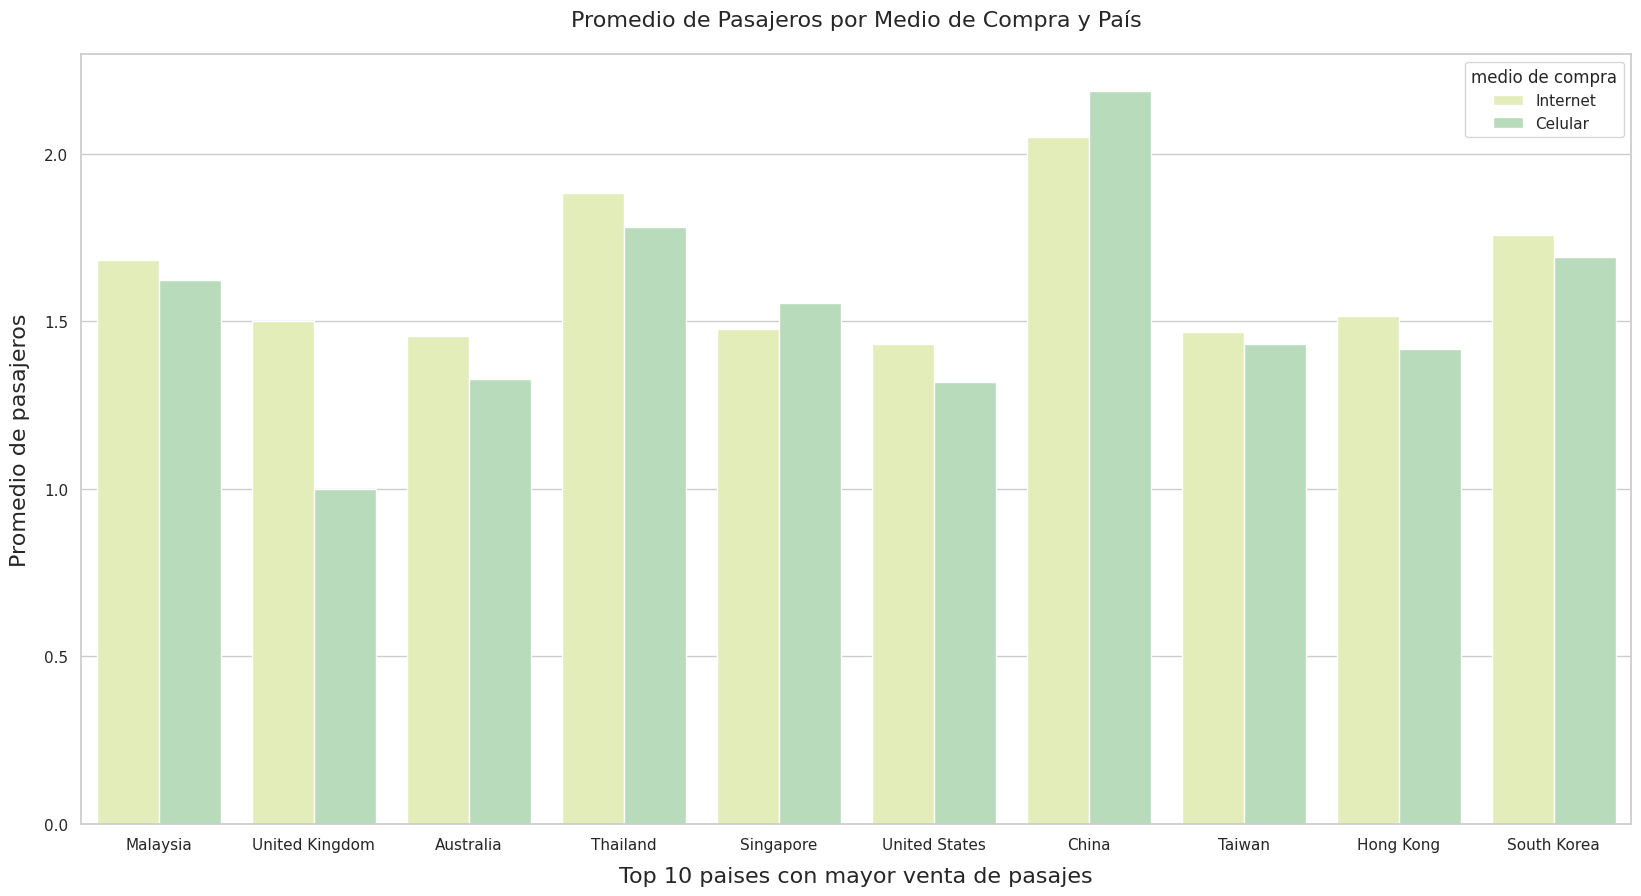

In [231]:
plt.figure(figsize=(20, 10))
sns.set_palette("YlGnBu")
sns.barplot(x='country', y='average_passengers', hue='sales_channel', data=promedio_pasajeros)
plt.title('Promedio de Pasajeros por Medio de Compra y País',pad =20,fontsize =16)
plt.xlabel("Top 10 paises con mayor venta de pasajes",fontsize =16,labelpad=10)
plt.ylabel("Promedio de pasajeros",fontsize =16,labelpad=10)
plt.legend(title='medio de compra')
#agarrar uno de los dos parametros y ordenar -> o sima de ambos


## 5 analizamos la cantidad de viajes por dia y por hora. Las horas laborales tendran menos viajes?


In [232]:
dias_de_viaje = info_de_compra.groupby(["flight_day","flight_hour"])[["num_passengers"]].sum().reset_index()
pasajeros_por_dia =dias_de_viaje.groupby("flight_day")[["num_passengers"]].sum().reset_index()
pasajeros_por_dia["flight_day"] =["Lunes","Martes","Miercoles","Jueves","Viernes","Sabado","Domingo"]

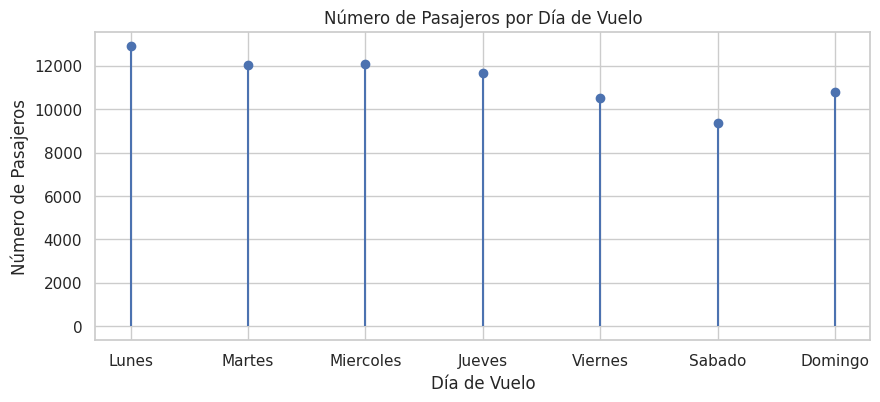

In [233]:
plt.figure(figsize=(10, 4))
plt.stem(pasajeros_por_dia['flight_day'], pasajeros_por_dia['num_passengers'], linefmt='b-', markerfmt='bo', basefmt=' ')
#                                                                               azul         circulo azul     sin linea base
plt.title('Número de Pasajeros por Día de Vuelo')
plt.xlabel('Día de Vuelo')
plt.ylabel('Número de Pasajeros')
plt.grid(True)
plt.show()

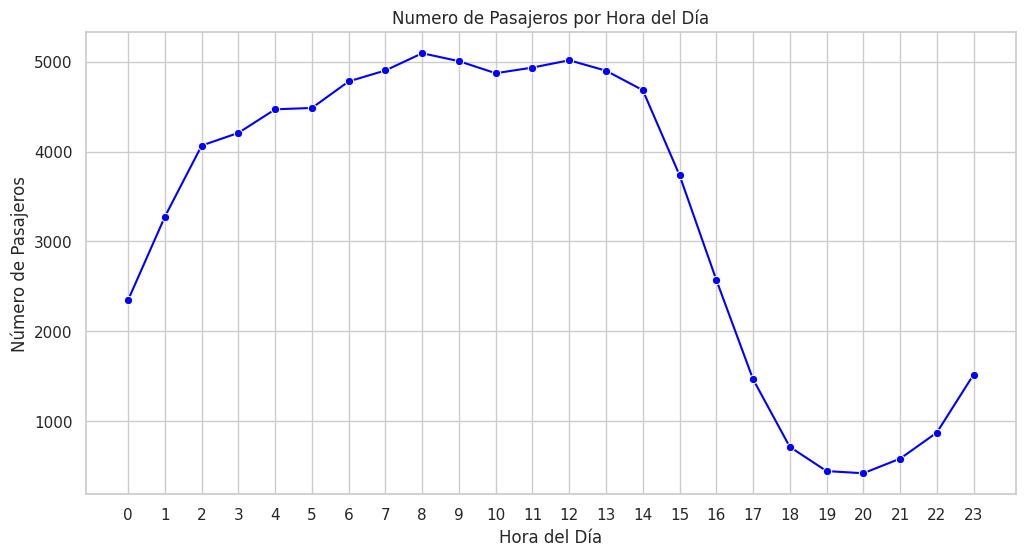

In [234]:
pasajeros_por_hora = dias_de_viaje.groupby("flight_hour")[["num_passengers"]].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x='flight_hour', y='num_passengers', data=pasajeros_por_hora, marker='o', color = 'blue')
plt.xlabel('Hora del Día')
plt.ylabel('Número de Pasajeros')
plt.title('Numero de Pasajeros por Hora del Día')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

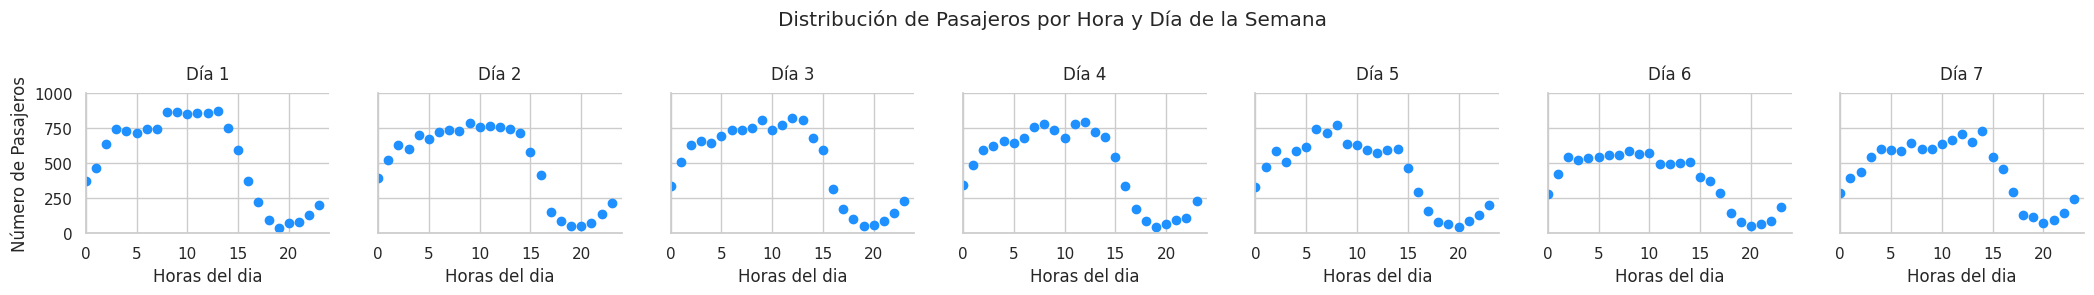

In [235]:
distribucion_psaajeros = sns.FacetGrid(dias_de_viaje, col="flight_day")
distribucion_psaajeros = distribucion_psaajeros.map(plt.scatter, "flight_hour", "num_passengers", color= 'dodgerblue').set_titles("Día {col_name}",pad=10)
distribucion_psaajeros.set_axis_labels("Horas del Día", "Número de Pasajeros")
plt.subplots_adjust(top=0.7)

plt.ylim(0,1000)
plt.xlim(0,24)
distribucion_psaajeros.fig.subplots_adjust(wspace=0.2, hspace=1)

distribucion_psaajeros.set_xlabels("Horas del dia")
distribucion_psaajeros.fig.suptitle('Distribución de Pasajeros por Hora y Día de la Semana')
plt.show()

# 3er Analisis de destinos mas elegidos por **trimestre**,queremos saber por cuatrimestre ,cuales fueron los destinos mas visitados


In [236]:
#suponemos que date es la fecha de la compra y debemos ver que fecha fue el vuelo segun la columna purchase lead,
#que es cuantos dias pasaron haste el momento de viajar

info_de_vuelos = vuelos_validos[["route","date","country","purchase_lead"]]
info_de_vuelos['origen'] = info_de_vuelos['route'].str.slice(0, 3)
info_de_vuelos['destino'] = info_de_vuelos['route'].str.slice(3)
info_de_vuelos.drop(columns=['route'], inplace=True)
info_de_vuelos['purchase_lead'] = pd.to_timedelta(info_de_vuelos['purchase_lead'], unit='D')
info_de_vuelos["vuelo"] = info_de_vuelos["date"] + info_de_vuelos["purchase_lead"]

In [237]:
def mes_a_trimestre(fecha):
  if 1 <= fecha.month <= 3:
    return 1
  elif 4 <= fecha.month <= 6:
    return 2
  elif 7 <= fecha.month <= 9:
    return 3
  else:
    return 4

info_de_vuelos.vuelo = info_de_vuelos.vuelo.map(mes_a_trimestre)
info_de_vuelos = info_de_vuelos.rename(columns={"vuelo": "trimestre"})

In [238]:
trimestres = info_de_vuelos.groupby("trimestre")["destino"].value_counts()
trimestres = trimestres.to_frame()
trimestres.columns = ["cantidad de personas"]
trimestres.reset_index(inplace = True)
df_grouped = trimestres.groupby(['trimestre', 'destino'])['cantidad de personas'].sum().reset_index()
df_top5 = df_grouped.groupby('trimestre').apply(lambda x: x.nlargest(5, 'cantidad de personas')).reset_index(drop=True)
df_top5 = df_top5.pivot(index = "destino",columns = "trimestre",values ="cantidad de personas").fillna(0)
df_top5['total_visitas'] = df_top5.sum(axis=1)

In [239]:
df_sorted = df_top5.sort_values(by='total_visitas', ascending=True)
df_sorted.drop(columns=['total_visitas'], inplace=True)
df_sorted.index = ["Australia(OOL)","Taiwan(TPE)","Australia(MEL)","Malasia(PEN)","Australia(PER)","Malasia(KUL)","Australia(SYD)"]

In [ ]:
sns.set_palette("YlGnBu")
df_sorted.plot(kind='bar', stacked=True)
plt.xlabel('Destinos')
plt.ylabel('Cantidad de personas')
plt.title('Los 5 destinos mas visitado por Trimestres (2018-2023)',fontsize=16,pad=20)
plt.legend(title='Trimestres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(range(len(df_sorted.index)), df_sorted.index, rotation=45, ha='right')
plt.tight_layout()
plt.show()

*** NUEVA HIPOTESIS***